In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
andel_avslag=df['Avslag_ind'].sum()/df['Avslag_ind'].count()

In [6]:
andel_avslag

0.0405982905982906

In [7]:
antall_avslag=df['Avslag_ind'].sum()

In [8]:
antall_avslag

19

In [9]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [10]:
df_encoded=df_encoded.dropna()

In [11]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)

In [12]:
df_encoded['sving'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, df_encoded['Kurvatur, horisontal'].abs(), 0)

In [13]:
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)

In [14]:
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)

In [15]:
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()

In [16]:
df_encoded['bakke_sigmoid'] = 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs()))

In [17]:
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100

In [18]:
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)

In [19]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [20]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_B - Regionale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Service,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage,sving_ind,sving,bakke_ind,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj
0,550.0,11.0,80.0,11,1,True,False,False,False,False,...,False,False,False,1,405.0,1,0.599888,0.5,0.599888,60.50
1,293.0,7.0,60.0,8,1,True,False,False,False,False,...,False,False,False,1,415.0,1,0.602286,1.0,0.602286,20.51
2,1500.0,13.0,80.0,2,4,False,False,False,True,False,...,False,False,False,1,182.0,1,0.545375,0.7,0.545375,195.00
3,15000.0,6.0,50.0,9,50,False,False,False,True,True,...,False,False,False,0,0.0,1,0.000000,0.3,1.000000,900.00
4,2980.0,12.0,80.0,5,8,False,False,False,True,False,...,False,False,False,0,0.0,1,0.000000,2.4,1.000000,357.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,1300.0,6.0,30.0,21,0,True,False,False,False,False,...,False,False,False,1,1520.0,1,0.820538,0.5,0.820538,78.00
464,500.0,10.0,60.0,12,2,False,False,True,False,False,...,False,False,False,1,1119.0,1,0.753803,0.2,0.753803,50.00
465,400.0,13.0,60.0,12,0,False,False,False,True,False,...,False,False,False,1,192.0,1,0.547853,5.5,0.547853,52.00
466,1600.0,15.0,80.0,8,6,False,False,False,True,True,...,False,True,False,1,524.0,1,0.628083,3.0,0.628083,240.00


In [21]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [22]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_B - Regionale hovedveger,...,bakke_ind sving_sigmoid bakke,bakke_ind sving_sigmoid bakke_sigmoid,bakke_ind sving_sigmoid antall_lange_kj,bakke_ind bakke bakke_sigmoid,bakke_ind bakke antall_lange_kj,bakke_ind bakke_sigmoid antall_lange_kj,sving_sigmoid bakke bakke_sigmoid,sving_sigmoid bakke antall_lange_kj,sving_sigmoid bakke_sigmoid antall_lange_kj,bakke bakke_sigmoid antall_lange_kj
0,550.0,11.0,80.0,11.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.299944,0.359866,36.293246,0.299944,30.25,36.293246,0.179933,18.146623,21.771896,18.146623
1,293.0,7.0,60.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.602286,0.362749,12.352889,0.602286,20.51,12.352889,0.362749,12.352889,7.439975,12.352889
2,1500.0,13.0,80.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.381762,0.297434,106.348090,0.381762,136.50,106.348090,0.208204,74.443663,57.999570,74.443663
3,15000.0,6.0,50.0,9.0,50.0,0.0,0.0,0.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.300000,270.00,900.000000,0.000000,0.000000,0.000000,270.000000
4,2980.0,12.0,80.0,5.0,8.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,2.400000,858.24,357.600000,0.000000,0.000000,0.000000,858.240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,1300.0,6.0,30.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.410269,0.673283,64.002001,0.410269,39.00,64.002001,0.336642,32.001001,52.516105,32.001001
452,500.0,10.0,60.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.150761,0.568219,37.690159,0.150761,10.00,37.690159,0.113644,7.538032,28.410962,7.538032
453,400.0,13.0,60.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.013192,0.300143,28.488360,3.013192,286.00,28.488360,1.650787,156.685982,15.607436,156.685982
454,1600.0,15.0,80.0,8.0,6.0,0.0,0.0,0.0,1.0,1.0,...,1.884248,0.394488,150.739830,1.884248,720.00,150.739830,1.183463,452.219489,94.677068,452.219489


In [23]:
andel_avslag=y.sum()/y.count()

In [24]:
#X=df_with_interactions
scaler = PowerTransformer()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [25]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_B - Regionale hovedveger,...,bakke_ind sving_sigmoid bakke,bakke_ind sving_sigmoid bakke_sigmoid,bakke_ind sving_sigmoid antall_lange_kj,bakke_ind bakke bakke_sigmoid,bakke_ind bakke antall_lange_kj,bakke_ind bakke_sigmoid antall_lange_kj,sving_sigmoid bakke bakke_sigmoid,sving_sigmoid bakke antall_lange_kj,sving_sigmoid bakke_sigmoid antall_lange_kj,bakke bakke_sigmoid antall_lange_kj
0,0.005604,0.131460,1.089650,0.279961,0.185316,1.077561,-0.105292,-0.546942,-0.641689,-0.478655,...,-0.264568,0.685733,0.831384,-1.082576,-0.580585,-0.040919,-0.341139,0.262641,0.691693,-0.792548
1,-0.616798,-1.009986,-0.393447,-0.256133,0.185316,1.077561,-0.105292,-0.546942,-0.641689,-0.478655,...,0.182129,0.695512,0.351837,-0.686202,-0.758109,-0.718146,0.097073,0.111493,0.153859,-0.996791
2,0.917639,0.542753,1.089650,-1.757163,1.133725,-0.928022,-0.105292,-0.546942,1.558387,-0.478655,...,-0.124524,0.461624,1.283580,-0.964990,0.228025,0.796032,-0.262756,0.803805,1.175487,0.037006
3,2.683467,-1.405659,-1.030527,-0.068014,2.022398,-0.928022,-0.105292,-0.546942,1.558387,2.089188,...,-0.972405,-1.061646,-1.059649,-1.082492,0.661389,3.032211,-0.969841,-1.096637,-1.128350,0.891280
4,1.489134,0.346535,1.089650,-0.900358,1.499309,-0.928022,-0.105292,-0.546942,1.558387,-0.478655,...,-0.972405,-1.061646,-1.059649,0.598495,1.505388,1.960872,-0.969841,-1.096637,-1.128350,1.735678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.793276,-1.405659,-2.071556,1.672134,-1.031995,1.077561,-0.105292,-0.546942,-0.641689,-0.478655,...,-0.079522,1.526407,1.074030,-0.926002,-0.457787,0.379551,0.043352,0.483788,1.127301,-0.473366
452,-0.086045,-0.106098,-0.393447,0.442238,0.676581,-0.928022,-0.105292,1.828348,-0.641689,-0.478655,...,-0.570804,1.287472,0.847796,-1.322167,-1.053380,-0.014338,-0.544115,-0.081494,0.824708,-1.242682
453,-0.304145,0.542753,-0.393447,0.442238,-1.031995,-0.928022,-0.105292,-0.546942,1.558387,-0.478655,...,1.343537,0.471864,0.725373,0.854230,0.700049,-0.206674,1.271655,1.073783,0.524442,0.519501
454,0.973125,0.889376,1.089650,-0.256133,1.360273,-0.928022,-0.105292,-0.546942,1.558387,2.089188,...,1.040001,0.800114,1.423075,0.335402,1.367682,1.105473,1.035688,1.436725,1.409773,1.258590


In [26]:
model = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
importances
# Select top 10 features
top_features = importances_sorted.index[:15]
X_top = X[top_features]

In [27]:
importances_sorted

Fartsgrense Avkjørsler bakke                                                                      0.005565
Avkjørsler antall_lange_kj                                                                        0.004916
ÅDT, total Avkjørsler antall_lange_kj                                                             0.004887
ÅDT, andel lange kjøretøy bakke_ind bakke_sigmoid                                                 0.004705
Fartsgrense bakke bakke_sigmoid                                                                   0.004617
                                                                                                    ...   
Avkjørsel, holdningsklasse_Meget streng Avkjørsel, holdningsklasse_Mindre streng sving_ind        0.000000
Avkjørsel, holdningsklasse_Meget streng Avkjørsel, holdningsklasse_Mindre streng sving            0.000000
Avkjørsel, holdningsklasse_Meget streng Avkjørsel, holdningsklasse_Mindre streng bakke_ind        0.000000
Avkjørsel, holdningsklasse_Meget stre

In [28]:
X=X_top

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [30]:
smote = ADASYN(sampling_strategy=0.3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [31]:
# Fit logistic regression
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [32]:
yps=model.predict_proba(X_test)

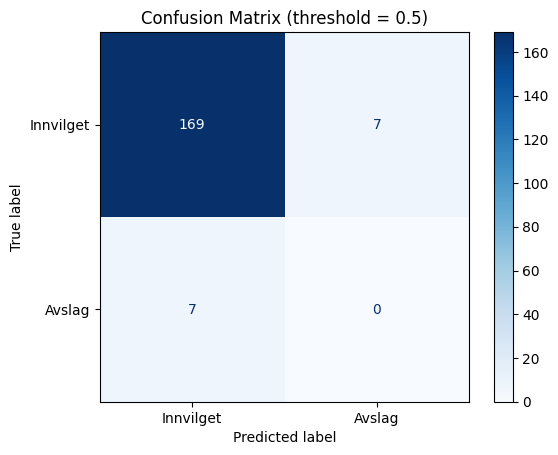

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.5 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [34]:
# Detailed metrics per class
print("Classification Report Logistic regression:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Logistic regression:
              precision    recall  f1-score   support

           0     0.9602    0.9602    0.9602       176
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.9235       183
   macro avg     0.4801    0.4801    0.4801       183
weighted avg     0.9235    0.9235    0.9235       183



In [35]:
model = RandomForestClassifier(n_estimators=5000,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000, n_jobs=-1)

In [36]:
yps=model.predict_proba(X_test)

In [37]:
X_test

,Fartsgrense Avkjørsler bakke,Avkjørsler antall_lange_kj,"ÅDT, total Avkjørsler antall_lange_kj","ÅDT, andel lange kjøretøy bakke_ind bakke_sigmoid",Fartsgrense bakke bakke_sigmoid,"ÅDT, andel lange kjøretøy Avkjørsler bakke_sigmoid",bakke bakke_sigmoid,bakke_ind bakke_sigmoid,bakke_ind bakke,Fartsgrense Avkjørsler bakke_sigmoid,Avkjørsler bakke antall_lange_kj,"ÅDT, andel lange kjøretøy bakke bakke_sigmoid",Avkjørsler bakke_sigmoid,bakke,bakke bakke_sigmoid antall_lange_kj
373,-0.015126,-0.235059,-0.202214,0.308840,0.138185,0.109679,-0.119317,1.151353,-0.353637,0.856265,-0.255655,-0.170236,0.368935,-0.360022,-0.161819
39,0.290028,-0.701884,-0.657227,-0.490292,0.089517,-0.472862,0.301663,-0.229245,0.378370,-0.390841,-0.208132,-0.037250,-0.029042,0.386350,-0.385507
340,0.503767,0.851285,0.881336,-0.384086,0.056050,-0.073191,0.259296,-0.331097,0.378370,-0.061446,1.010336,0.041932,0.316020,0.386350,0.719182
218,-0.407381,2.022700,1.736657,-0.195462,-1.188252,0.619860,-1.180572,-0.826891,-0.956625,0.150597,0.714262,-1.034260,0.531071,-0.986304,0.016368
155,0.985524,-0.208718,-0.326910,0.473978,1.023635,0.631510,0.858159,1.151353,0.528909,1.513318,0.263684,0.744082,0.867009,0.537896,0.256255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2.017396,-0.419809,-0.722552,1.197421,2.066731,1.372411,1.828151,1.151353,1.484982,1.716181,0.606386,2.116539,1.015295,1.484236,0.575778
193,0.302071,0.131064,0.070454,-0.015666,0.047340,0.079177,0.248252,-0.147999,0.295824,-0.210856,0.399355,0.227119,0.161214,0.302967,0.246722
351,-0.393468,0.413229,0.513548,0.308840,-0.319903,0.109679,-0.383767,1.151353,-0.580869,0.298866,0.037628,-0.396012,0.368935,-0.594839,0.184731
399,-1.269852,-0.579125,-0.651860,1.805488,-1.084065,0.381339,-1.282972,1.151353,-1.322215,-0.192685,-1.243733,-0.886437,-0.490572,-1.370898,-1.110426


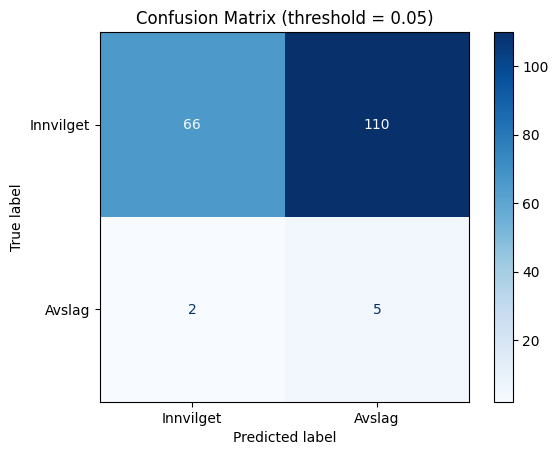

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [39]:
# Detailed metrics per class
print("Classification Report Random Forrest:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Random Forrest:
              precision    recall  f1-score   support

           0     0.9706    0.3750    0.5410       176
           1     0.0435    0.7143    0.0820         7

    accuracy                         0.3880       183
   macro avg     0.5070    0.5446    0.3115       183
weighted avg     0.9351    0.3880    0.5234       183



In [40]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

In [41]:
print(importances_sorted)

bakke_ind bakke_sigmoid                               0.104850
ÅDT, total Avkjørsler antall_lange_kj                 0.097168
Avkjørsler bakke antall_lange_kj                      0.089347
ÅDT, andel lange kjøretøy bakke_ind bakke_sigmoid     0.082867
Fartsgrense Avkjørsler bakke_sigmoid                  0.075285
Avkjørsler antall_lange_kj                            0.075076
Avkjørsler bakke_sigmoid                              0.067153
ÅDT, andel lange kjøretøy Avkjørsler bakke_sigmoid    0.061904
bakke bakke_sigmoid antall_lange_kj                   0.058862
Fartsgrense bakke bakke_sigmoid                       0.055620
Fartsgrense Avkjørsler bakke                          0.053798
bakke bakke_sigmoid                                   0.053210
bakke                                                 0.042187
bakke_ind bakke                                       0.041531
ÅDT, andel lange kjøretøy bakke bakke_sigmoid         0.041143
dtype: float64


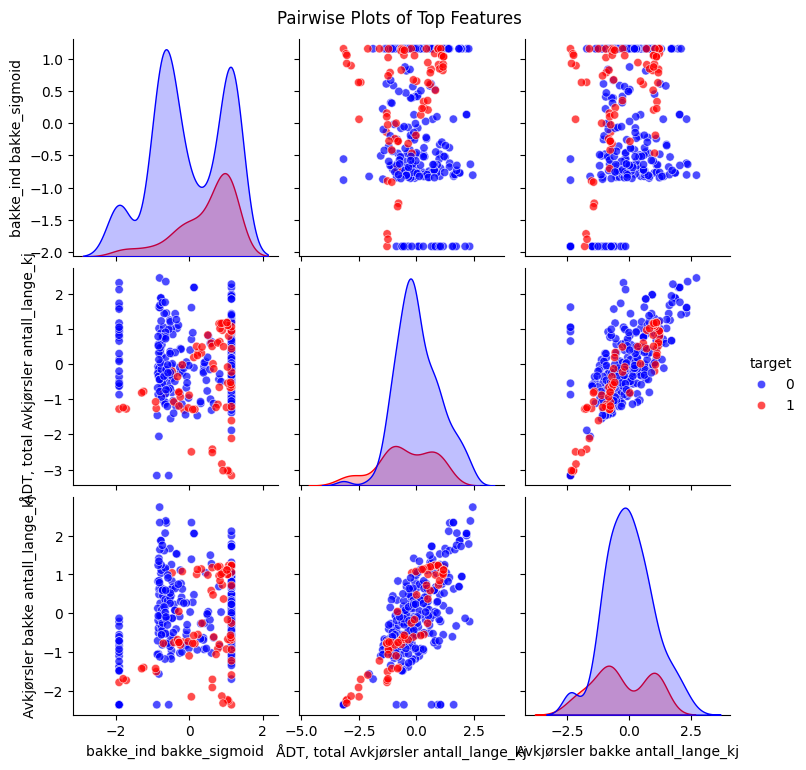

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 4 features
top_features = importances_sorted.index[:3]

# Subset data
X_top = X_train[top_features].copy()
X_top['target'] = y_train  # add the target

# Pairwise scatter plots
sns.pairplot(
    X_top,
    vars=top_features,
    hue='target',            # color by target
    palette={0: "blue", 1: "red"}, 
    plot_kws={'alpha': 0.7}
)
plt.suptitle("Pairwise Plots of Top Features", y=1.02)
plt.show()

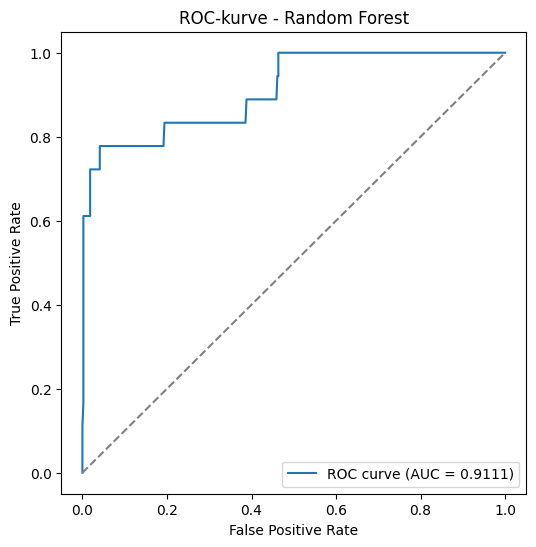

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Sannsynligheter for den positive klassen
y_proba = model.predict_proba(X)[:, 1]

# Beregn ROC-verdier
fpr, tpr, thresholds = roc_curve(y, y_proba)
auc = roc_auc_score(y, y_proba)

# Plott ROC-kurve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-kurve - Random Forest')
plt.legend(loc='lower right')
plt.show()

In [44]:
#Kort sagt: hver x-verdi viser hvor mange negative som blir feil, hver y-verdi viser hvor mange positive som blir riktig.

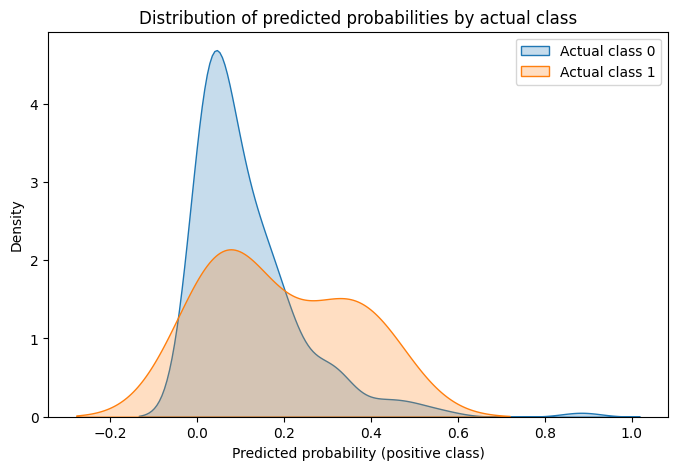

In [45]:
y_proba = yps[:, 1]

# Combine into one DataFrame for easy plotting
import pandas as pd
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()